# Intro and *Invocación Para Ponerse las Pilas*

Now that we have learned a bit about Tensorflow and its function as a Deep Learning library, we will jump into the deep end and force ourselves to swim. The next several lessons will be explanations of fully functional tensorflow code in several applications. We will continue to explain all high level functions with low-level code, before accepting it, especially when it comes to mathematical transformations. 

We're jumping way ahead of our last lesson and will be hit with a lot of information right now, so I ask you to *ponerse las pilas*!

Here's a quick outline of all the things that we will do. Note that there is some code early on that we will eventually discard for the sake of using best practices, but which we show initially for demonstration.

* Intro to a dataset object and exploring the MNIST data
* Train a neural network classifier to recognize handwritten digits in the MNIST
    * TF graph defined in global namespace

# MNIST handwritten dataset Intro

This is a very common dataset that is often used as a "hello world" trivial introduction to Machine Learning image processing. It was created by the great Yann Lecunn years ago as a demonstration of convolution neural networks and we will use it for the same purpose. 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pandas_datareader.data as web
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## explore data and learn about Datasets object

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
# not sure why this code works the second time I run it

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
mnist # this is a Datasets object from the Datasets API

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x11bec7320>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x11bec72e8>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x11bec7390>)

In [4]:
print(mnist.train.next_batch(10)[0].shape) # 784 = 28^2
print(mnist.train.next_batch(10)[1].shape) # one hot vector of numbers -> 0,1,2,3,4

(10, 784)
(10, 10)


In [5]:
d = mnist.train.next_batch(1)
i = d[0].reshape([28,28])
a= d[1]

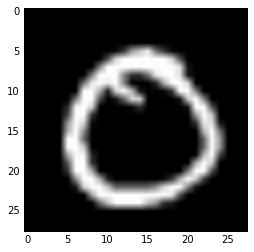

In [6]:
plt.gray()
plt.imshow(i)

In [7]:
a

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## Make a Model

Lets start with a slightly messy implimentation of this simple problem. Here all the code is basically written out as global variables and we dont handle variable definitions well. If our model were more complex this code would be very messy; however, it helps us to see all the moving parts layed out on the floor the first time through.

In [369]:
tf.reset_default_graph() 

In [370]:
img_dim1 = 28
img_dim2 = 28
num_classes = 10

n_input = img_dim1 * img_dim2
n_hidden_1 = 10 # 1st layer number of features
n_hidden_2 = 10 # 2nd layer number of features
n_out = num_classes # out dim

In [371]:
# define placeholders
X = tf.placeholder(dtype=tf.float32, shape = [None, 784])
Y = tf.placeholder(dtype=tf.float64, shape = [None, 10])    

# define variables
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_out]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_out]))
}

# define model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)  # ReLU non-linearity stops linear functions from collapsing into a single linear function!
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Construct model
model = multilayer_perceptron(X, weights, biases)

In [372]:
# define loss: softmax cross entropy
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits = model))

In [373]:
# define optimizer
optimizer = tf.train.GradientDescentOptimizer(.001)
train = optimizer.minimize(loss)

In [374]:
# create session and initialize variables
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [375]:
# iterate over training step and log the loss function over time
losses = []
for i in range(5000):
    data = mnist.train.next_batch(100)
    sess.run(train, {X: data[0], Y: data[1]})
    if (i % 100 == 0) :
        l = sess.run(loss, {X: data[0], Y: data[1]})
        losses.append(l)
        if i%1000==0:
            print(l)
      

60.1083
3.5916
3.5458
2.94452
2.82686


As training progresses we can see our loss function decreasing. This function is very useful for seeing how our model is doing in training


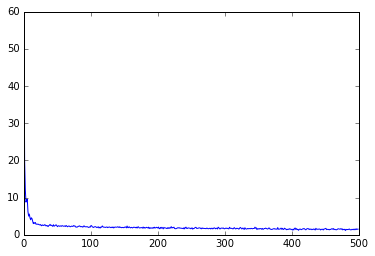

In [38]:
plt.plot(losses)

In [45]:
# get results of model compared to target (Y).
dense = tf.argmax(Y, axis=1)
dense2 = tf.argmax(model, axis=1)

target = sess.run(dense, {X: data[0], Y: data[1]})
predict = sess.run(dense2, {X: data[0], Y: data[1]})
result = mean(target == predict)*100
print('Percentage correct: {}'.format(result))

Percentage correct: 51.0


In [47]:
tf.reset_default_graph() 

# Variable Scope

If we define a variable from within a function we begin to run into problems. We need variables to have unique names in our graph. This problem is resolved by using variable scopes. 

In [48]:
# Define placeholders first
X = tf.placeholder(dtype=tf.float32, shape = [None, 784])
Y = tf.placeholder(dtype=tf.float64, shape = [None, 10])    

In [49]:
# We define a function that we will reuse for each fully connected layer. 
def fully_connected_relu(input, output_dim, relu=True):
    input_dim = input.get_shape().as_list()[1]
    weights = tf.get_variable("weights",shape=[input_dim, output_dim])
    biases = tf.get_variable("biases", shape=[output_dim])
    out = tf.add(tf.matmul(input, weights), biases)
    if relu:
        out = tf.nn.relu(out)
    return out

In [50]:
# we solve the problem by calling the function from separate variable scopes:
with tf.variable_scope("fconn1"):
    layer1 = fully_connected_relu(X, 10)
with tf.variable_scope("fconn2"):
    layer2 = fully_connected_relu(layer1, 10)
with tf.variable_scope("out"):
    out = fully_connected_relu(layer2, 10, relu=False)

In [27]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)


In [22]:
data = mnist.train.next_batch(100)
sess.run(out, {X: data[0], Y: data[1]})

array([[ -1.13592327e-01,   5.40731370e-01,  -4.53934968e-02,
         -2.51842409e-01,  -1.62925363e-01,   2.20705271e-01,
         -8.29263389e-01,   1.87850088e-01,  -3.79763842e-02,
          5.99137247e-01],
       [ -7.03424513e-02,   3.99404824e-01,  -6.16735816e-02,
         -3.76412868e-01,   1.11092061e-01,  -9.40153003e-03,
         -1.28008115e+00,   3.43054712e-01,  -9.45927203e-02,
          7.81403780e-01],
       [  1.47356912e-01,   2.49533758e-01,  -2.21233130e-01,
         -3.02651167e-01,  -6.91851974e-03,   1.73129559e-01,
         -8.92323017e-01,   4.12981778e-01,  -2.60015905e-01,
          5.61587095e-01],
       [  2.49858499e-01,   1.16952240e-01,  -2.51797765e-01,
         -1.35159224e-01,   4.15011346e-02,   2.87272543e-01,
         -1.14785016e+00,  -2.80248880e-01,  -2.83178389e-01,
          8.68633270e-01],
       [  1.52379096e-01,   1.97381273e-01,  -1.66648835e-01,
         -4.33311105e-01,  -5.20137846e-02,   2.21486852e-01,
         -1.02502000e+00

In [19]:
tf.reset_default_graph() 

## Structuring Our Model

Again looking towards the inevitable complexity of our models later on, we must now think about writing well-structured code. 

Definining our graph as a **class object** naively is problematic because of the nature of tensors. Remember each computation is a node with new tensor defined at that point. If we defined the prediction part of the graph as a method and called it a second time when we evaluated the loss, we would create a mess of nodes. We use **decorators** to solve this problem in a pythonic way.

In [20]:
import functools

# this is a decorator that does two things on a function: 
#    (1) makes it behave like a `@property` that is only evaluated once
#    (2) sets the variable scope of of all variables as the name of the function

def define_scope(function):
    attribute = '_cache_' + function.__name__

    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(function.__name__):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)

    return decorator

In [21]:
def fully_connected_relu(input, output_dim, relu=True):
    input_dim = input.get_shape().as_list()[1]
    weights = tf.get_variable("weights",shape=[input_dim, output_dim])
    biases = tf.get_variable("biases", shape=[output_dim])
    out = tf.add(tf.matmul(input, weights), biases)
    if relu:
        out = tf.nn.relu(out)
    return out

We also will feed a dictionary (actually a class with attributes) of **hyperparameters** to the model's constructor. This will allow flexibility as well as using some of the useful features that the TF community has built. This code allows us to define hyperparameters and accept command line arguments to override them. 

In [22]:
# Define a command line flag to pass name=value pairs.
# For example using argparse:
#import argparse
#parser = argparse.ArgumentParser(description='Train my model.')
#parser.add_argument('--hparams', type=str,
#                    help='Comma separated list of "name=value" pairs.')
#args = parser.parse_args()

# Set hyperparameters
hparams = tf.contrib.training.HParams(
    LEARNING_RATE=0.001, 
    HIDDEN_DIM1=10,
    HIDDEN_DIM2=10
)

# Override hyperparameters values by parsing the command line
#hparams.parse(args.hparams)


In [23]:
class nn_classifier:
    def __init__(self, input_data, target_data, hparams): 
    
        self.input_data = input_data
        self.target_data = target_data
        self.in_dim, self.out_dim = self.get_inout_dim()
        
        self.learning_rate = hparams.LEARNING_RATE
        self.hidden_dim1 = hparams.HIDDEN_DIM1
        self.hidden_dim2 = hparams.HIDDEN_DIM2

        self.prediction 
        self.loss 
        self.train 
        self.evaluate 
        
    def get_inout_dim(self):
        in_dim = self.input_data.get_shape().as_list()[1]
        out_dim = self.target_data.get_shape().as_list()[1]
        return in_dim, out_dim
    
    @define_scope
    def prediction(self):
        
        with tf.variable_scope("fconn1"):
            layer1 = fully_connected_relu(self.input_data, self.hidden_dim1)
        with tf.variable_scope("fconn2"):
            layer2 = fully_connected_relu(layer1, self.hidden_dim2)
        with tf.variable_scope("out"):
            out = fully_connected_relu(layer2, self.out_dim, relu=False)
        return out
    
    @define_scope
    def loss(self):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                labels = self.target_data, logits = self.prediction))
        return loss
    
    @define_scope
    def train(self):
        optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
        train = optimizer.minimize(self.loss)
        return train
    
    @define_scope
    def evaluate(self):
        dense = tf.argmax(Y, axis=1)
        dense2 = tf.argmax(self.prediction, axis=1)
        correct = tf.equal(dense, dense2)
        score = tf.reduce_mean(tf.cast(correct, tf.float32))
        return score

In [24]:
# create the graph and initialize it in a session
X = tf.placeholder(dtype=tf.float32, shape = [None, 784])
Y = tf.placeholder(dtype=tf.float64, shape = [None, 10])
model = nn_classifier(X, Y, hparams)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [25]:
# iterate through evaluations
for i in range(10):
    images, labels = mnist.test.images, mnist.test.labels
    loss, evaluate = sess.run([model.loss, model.evaluate], feed_dict={X: images, Y: labels})
    print('Test accuracy {:6.2f}% \t\tX-Ent Loss: {:6.2f}'.format(100 * evaluate, loss))
    # nested iterate through training steps
    for i in range(1000):
        data = mnist.train.next_batch(100)
        images, labels = data[0], data[1]
        sess.run(model.train, {X: data[0], Y: data[1]})

Test accuracy  14.77% 		X-Ent Loss:   2.37
Test accuracy  27.05% 		X-Ent Loss:   2.19
Test accuracy  31.94% 		X-Ent Loss:   1.98
Test accuracy  46.94% 		X-Ent Loss:   1.75
Test accuracy  57.17% 		X-Ent Loss:   1.51
Test accuracy  64.80% 		X-Ent Loss:   1.25
Test accuracy  71.58% 		X-Ent Loss:   1.05
Test accuracy  75.74% 		X-Ent Loss:   0.92
Test accuracy  77.72% 		X-Ent Loss:   0.81
Test accuracy  79.32% 		X-Ent Loss:   0.74


In [363]:
tf.reset_default_graph() 

## add convolutions using model inheritance

In [364]:
# we define two functions that represent layers of a convolutional net. We already have the fully connected layer
def conv_relu(input, kernel_shape, bias_shape):
    # Create variable named "weights".
    weights = tf.get_variable("weights", kernel_shape,
        initializer=tf.random_normal_initializer())
    # Create variable named "biases".
    biases = tf.get_variable("biases", bias_shape,
        initializer=tf.constant_initializer(0.0))
    conv = tf.nn.conv2d(input, weights,
        strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv + biases)

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [365]:
class conv_net_classifier(nn_classifier):
    def __init__(self, input_data, target_data, hparams):
        super().__init__(input_data, target_data, hparams)
    
    @define_scope
    def prediction(self):
        
        x_image = tf.reshape(self.input_data, [-1, 28, 28, 1]) #input shape starts as [-1,28*28], now we make 2d grid and add color chanell
        with tf.variable_scope("conv_maxp_1"):
            conv1 = conv_relu(x_image, [5, 5, 1, 32], [32]) #[-1,28,28,32] 
            max_p1 = max_pool_2x2(conv1) # [-1,14,14,32]
        with tf.variable_scope("conv_maxp_2"):
            conv2 = conv_relu(max_p1, [5, 5, 32, 64], [64]) #[-1,14,14,64]
            max_p2 = max_pool_2x2(conv2) # [-1,7,7,64]
        with tf.variable_scope("full_con_1"):
            max_p2_flat = tf.reshape(max_p2, [-1, 7*7*64]) 
            fc_1 = fully_connected_relu(max_p2_flat, 1024) #[-1,1024]
        with tf.variable_scope('out'):
            out = fully_connected_relu(fc_1, self.out_dim, relu=False)
        return out
    
    @define_scope
    def train(self):
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        train = optimizer.minimize(self.loss)
        return train
        

In [366]:
hparams = tf.contrib.training.HParams(
    LEARNING_RATE=0.001, 
    HIDDEN_DIM1=10,
    HIDDEN_DIM2=10
)

In [367]:
# create the graph and initialize it in a session
X = tf.placeholder(dtype=tf.float32, shape = [None, 784])
Y = tf.placeholder(dtype=tf.float64, shape = [None, 10])
model = conv_net_classifier(X, Y, hparams)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [347]:
# iterate through evaluations
for i in range(10):
    images, labels = mnist.test.images, mnist.test.labels
    loss, evaluate = sess.run([model.loss, model.evaluate], feed_dict={X: images, Y: labels})
    print('Test accuracy {:6.2f}% \t\tX-Ent Loss: {:6.2f}'.format(100 * evaluate, loss))
    # nested iterate through training steps
    for i in range(10):
        data = mnist.train.next_batch(100)
        images, labels = data[0], data[1]
        sess.run(model.train, {X: data[0], Y: data[1]})

Test accuracy  13.55% 		X-Ent Loss:  59.84
Test accuracy  40.84% 		X-Ent Loss: 160.82
Test accuracy  61.52% 		X-Ent Loss:  23.26
Test accuracy  77.55% 		X-Ent Loss:   7.72
Test accuracy  87.46% 		X-Ent Loss:   3.93
Test accuracy  90.43% 		X-Ent Loss:   2.45
Test accuracy  91.41% 		X-Ent Loss:   2.01
Test accuracy  90.33% 		X-Ent Loss:   2.06
Test accuracy  91.53% 		X-Ent Loss:   1.60
Test accuracy  91.40% 		X-Ent Loss:   1.59


This way of coding in tensorflow is far superior to simply coding as we go for each model. It allows us to interchangably plug in ideas while we test their effectiveness against each other, allowing us to tune models and hyperparameters.

## More excercises

* Create a convolutional relu function in base TF
    * Create max pool and relu functions in base TF
    * cross entropy: tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.softmax(y)), reduction_indices=[1]))
* Dropout layer
* Experiment with code structure from https://blog.metaflow.fr/tensorflow-a-proposal-of-good-practices-for-files-folders-and-models-architecture-f23171501ae3
    * Modularize class across a directory
    * Create a generalized model class that is meant to get overwritten
* Question: When I overwrite a method of a class, does the first graph already get built? No, but notice that there is a second set of the

In [376]:
 tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[<tf.Variable 'Variable:0' shape=(784, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(10, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(10, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'Variable_4:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'Variable_5:0' shape=(10,) dtype=float32_ref>]